# Data pre-processing

Pre-processing of data from notebook [Data Process](./dataProcess.ipynb)

In [1]:
%%capture

import sys
!{sys.executable} -m pip install nbformat

%run -G ./dataProcess.ipynb

## First Model Building and Evaluation

We are going to train a Logistic Regression Model to as a first approach to the model selection. 

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score

In [3]:
df

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V20,Hour,Class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.475312,0.510600,0.252484,0.680908,0.635591,0.434392,0.737173,0.655066,0.594863,0.582942,0.0,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.453981,0.505267,0.381188,0.744342,0.641219,0.464105,0.727794,0.640681,0.551930,0.579530,0.0,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.410603,0.513018,0.322422,0.706683,0.640473,0.357443,0.763381,0.644945,0.386683,0.585855,0.0,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.414999,0.507585,0.271817,0.710910,0.636372,0.415653,0.711253,0.788492,0.467058,0.578050,0.0,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.490950,0.524303,0.236355,0.724477,0.608406,0.434995,0.724243,0.650665,0.626060,0.584615,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283721,0.756448,0.873531,0.666991,0.160317,0.729603,0.236810,0.235393,0.528729,0.598850,0.190550,0.806406,0.801627,0.484577,0.789000,0.688412,0.509985,0.595979,1.0,0
283722,0.945845,0.766677,0.872678,0.219189,0.771561,0.273661,0.265504,0.482925,0.488530,0.276355,0.738709,0.623352,0.426717,0.730383,0.569303,0.442620,0.580900,1.0,0
283723,0.990905,0.764080,0.781102,0.227202,0.783425,0.293496,0.263547,0.477677,0.498692,0.309763,0.706572,0.628885,0.453827,0.740239,0.680504,0.518236,0.580280,1.0,0
283724,0.954209,0.772856,0.849587,0.282508,0.763172,0.269291,0.261175,0.476287,0.500464,0.170288,0.667901,0.661171,0.429998,0.745946,0.729908,0.789612,0.581622,1.0,0


Plot the correlation matrix plots again to see the how strongly correlated the features are, which can help us determine if PCA is a good choice.

<AxesSubplot: >

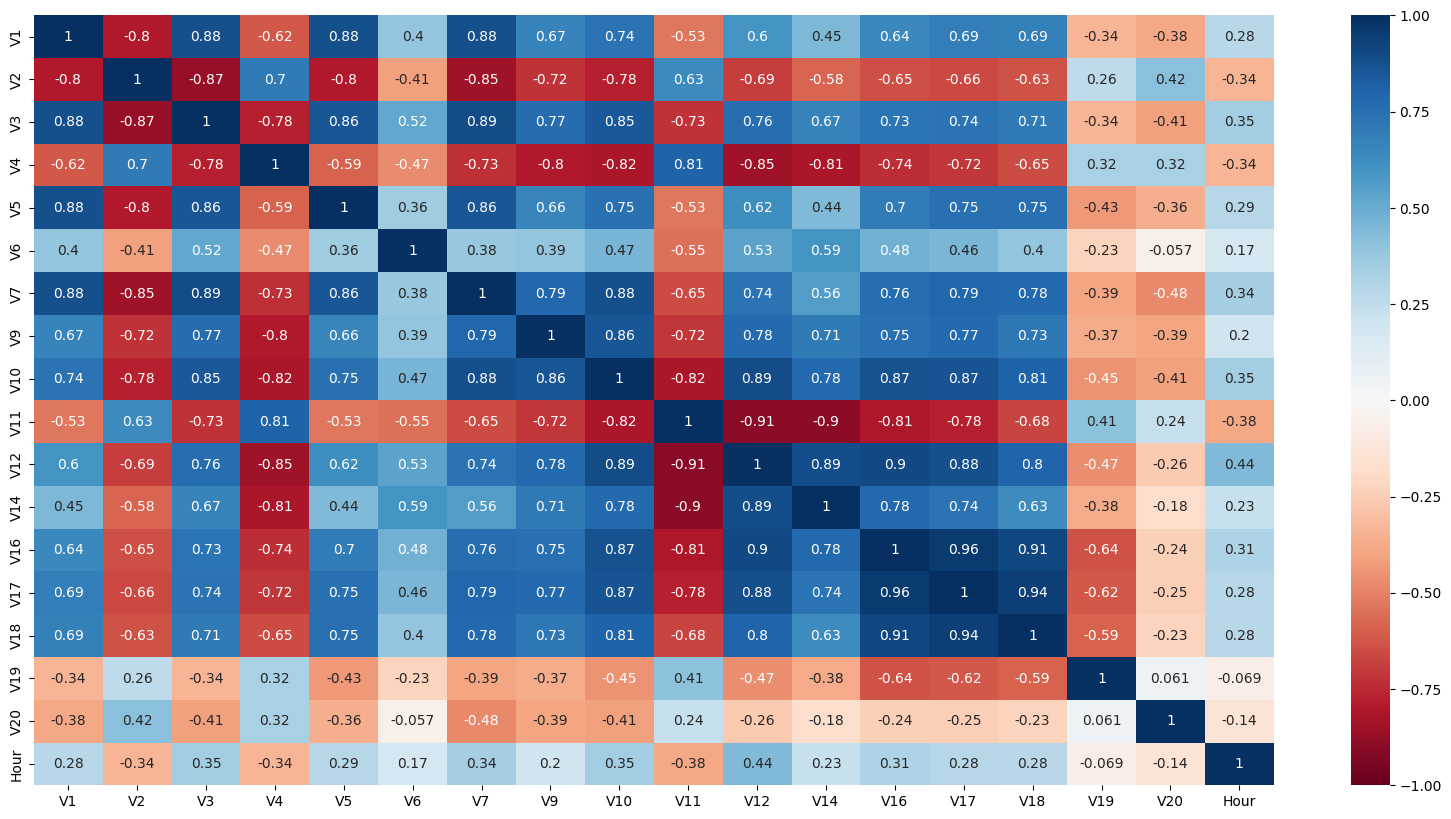

In [4]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
df_overSampled, y_overSampled = smote.fit_resample(X=df, y=df['Class'])
df_overSampled = df_overSampled.drop(['Class'], axis=1)
corr = df_overSampled.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, cmap= 'RdBu')

In [5]:

X = df.drop('Class', axis=1)
y = df['Class']
print(X.shape)
print(y.shape)


(283726, 18)
(283726,)


Correlation matrix plots shows features are strongly correlated. So next we look at how PCA dimensionality reduction effcts the logistic regression model.

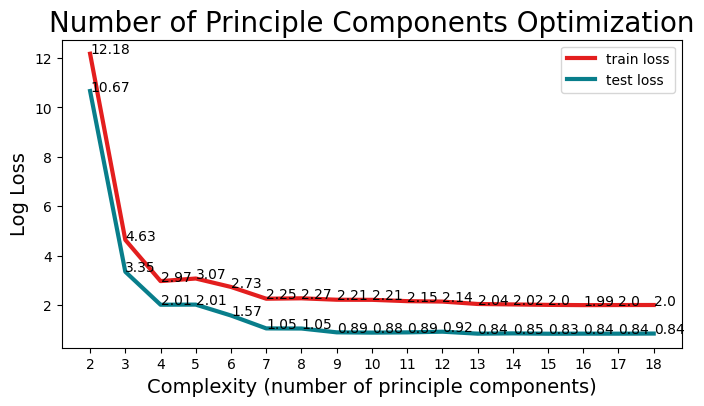

In [6]:
from sklearn import decomposition
loss_train_df = []
loss_test_df = []

from imblearn.under_sampling import RandomUnderSampler

for k in range(2, 19):
    X = df.drop('Class', axis=1)
    y = df['Class']
    logisticRegr = LogisticRegression(max_iter=1200)
    pca = decomposition.PCA(n_components=k)
    pca.fit(X)
    X = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #Oversample the train set
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    logisticRegr.fit(X_train, y_train)
    train_predictions = logisticRegr.predict(X_train)
    test_predictions = logisticRegr.predict(X_test)

    loss_train = log_loss(y_train, train_predictions)
    loss_test = log_loss(y_test, test_predictions)
    loss_train_df.append({'k': k, 'loss': loss_train})
    loss_test_df.append({'k': k, 'loss': loss_test})

loss_train_df = pd.DataFrame(loss_train_df)
loss_test_df = pd.DataFrame(loss_test_df)


plt.figure(figsize=(8, 4))
plt.plot(loss_train_df['k'], loss_train_df['loss'], lw=3, c='#e31e1e', label='train loss')
for a,b in zip(loss_train_df['k'], loss_train_df['loss']): 
    plt.text(a, b, str(round(b, 2)))
plt.plot(loss_test_df['k'], loss_test_df['loss'], lw=3, c='#087E8B', label='test loss')
for a,b in zip(loss_test_df['k'], loss_test_df['loss']): 
    plt.text(a, b, str(round(b, 2)))
plt.title("Number of Principle Components Optimization", size=20)
plt.xlabel('Complexity (number of principle components)', size=14)
plt.xticks(np.arange(2, k+1, 1))
plt.ylabel('Log Loss', size=14)
plt.legend()
plt.show()

We can see that using PCA (n_components=7) is a good choice. It recudes the dimension of original data and still has best performance.

Next we look at how increasing the dimension of the data effects the logistic regression model.

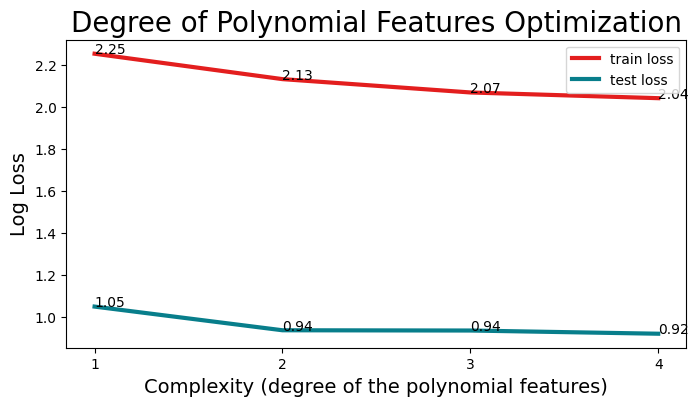

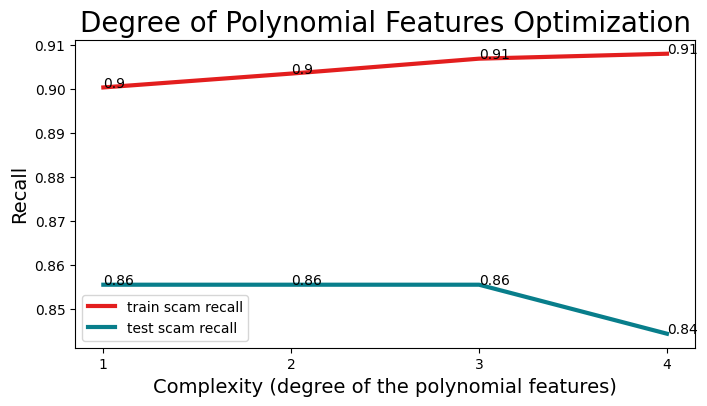

In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

pca = decomposition.PCA(n_components=7)
pca.fit(X)
X = pca.transform(X)

loss_train_df = []
loss_test_df = []
recall_train_df = []
recall_test_df = []

for k in range(1, 5):
    logisticRegr = LogisticRegression(max_iter=1200)
    X_poly = PolynomialFeatures(k).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
    #remember to oversample
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    logisticRegr.fit(X_train, y_train)
    train_predictions = logisticRegr.predict(X_train)
    test_predictions = logisticRegr.predict(X_test)

    loss_train = log_loss(y_train, train_predictions)
    loss_test = log_loss(y_test, test_predictions)
    loss_train_df.append({'k': k, 'loss': loss_train})
    loss_test_df.append({'k': k, 'loss': loss_test})

    recall_train = recall_score(y_train, train_predictions)
    recall_test = recall_score(y_test, test_predictions)
    recall_train_df.append({'k': k, 'recall': recall_train})
    recall_test_df.append({'k': k, 'recall': recall_test})

loss_train_df = pd.DataFrame(loss_train_df)
loss_test_df = pd.DataFrame(loss_test_df)

recall_train_df = pd.DataFrame(recall_train_df)
recall_test_df = pd.DataFrame(recall_test_df)

# Plot log loss
plt.figure(figsize=(8, 4))
plt.plot(loss_train_df['k'], loss_train_df['loss'], lw=3, c='#e31e1e', label='train loss')
for a,b in zip(loss_train_df['k'], loss_train_df['loss']): 
    plt.text(a, b, str(round(b, 2)))
plt.plot(loss_test_df['k'], loss_test_df['loss'], lw=3, c='#087E8B', label='test loss')
for a,b in zip(loss_test_df['k'], loss_test_df['loss']): 
    plt.text(a, b, str(round(b, 2)))
plt.title(f"Degree of Polynomial Features Optimization", size=20)
plt.xlabel('Complexity (degree of the polynomial features)', size=14)
plt.xticks(np.arange(1, k+1, 1))
plt.ylabel('Log Loss', size=14)
plt.legend()
plt.show()

# Plot recall
plt.figure(figsize=(8, 4))
plt.plot(recall_train_df['k'], recall_train_df['recall'], lw=3, c='#e31e1e', label='train scam recall')
for a,b in zip(recall_train_df['k'], recall_train_df['recall']): 
    plt.text(a, b, str(round(b, 2)))
plt.plot(recall_test_df['k'], recall_test_df['recall'], lw=3, c='#087E8B', label='test scam recall')
for a,b in zip(recall_test_df['k'], recall_test_df['recall']): 
    plt.text(a, b, str(round(b, 2)))
plt.title(f"Degree of Polynomial Features Optimization", size=20)
plt.xlabel('Complexity (degree of the polynomial features)', size=14)
plt.xticks(np.arange(1, k+1, 1))
plt.ylabel('Recall', size=14)
plt.legend()
plt.show()

We can see that once we increase the dimension of the data, the train loss decreases but the test loss does not decrease much. Additionally, the scam recall decreases on test. So increasing the dimension of the data is not a good choice (may overfit).

It is important to note that the test loss is less than the train loss. It is probably due to imbalanced data.

The negative cases are many more than the positive cases in both sets, so we are oversampling the train data to have the same number. However, in the test data there are still many more negative cases. So if the model is underfitting, it would classify all test cases as negative, resulting in low loss (there are so few positive cases that it won't penalize much).

In [8]:
X = df.drop('Class', axis=1)
y = df['Class']
logisticRegr = LogisticRegression(max_iter=1200)

pca = decomposition.PCA(n_components=7)
pca.fit(X)
X = pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
logisticRegr.fit(X_train, y_train)
train_predictions = logisticRegr.predict(X_train)
test_predictions = logisticRegr.predict(X_test)

### Train results

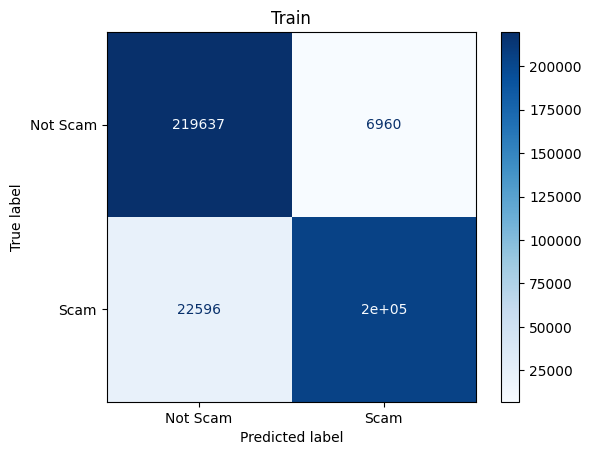

              precision    recall  f1-score   support

           0       0.91      0.97      0.94    226597
           1       0.97      0.90      0.93    226597

    accuracy                           0.93    453194
   macro avg       0.94      0.93      0.93    453194
weighted avg       0.94      0.93      0.93    453194



In [10]:
cm = confusion_matrix(y_train, train_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Scam', 'Scam'])
disp.plot(cmap='Blues')
plt.title('Train')
plt.show() 

cr = classification_report(y_train,train_predictions)
print(cr)

### Test results

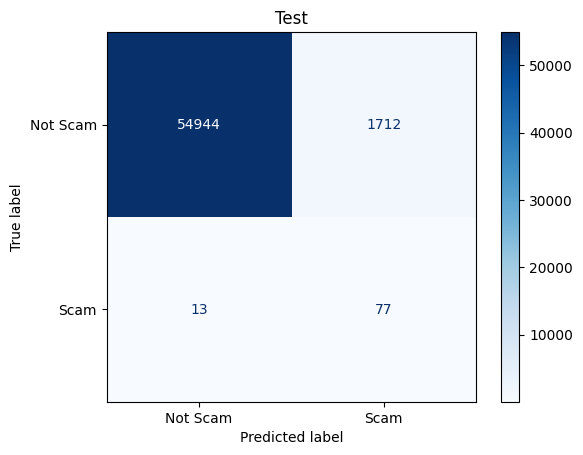

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56656
           1       0.04      0.86      0.08        90

    accuracy                           0.97     56746
   macro avg       0.52      0.91      0.53     56746
weighted avg       1.00      0.97      0.98     56746



In [11]:
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Scam', 'Scam'])
disp.plot(cmap='Blues')
plt.title('Test')
plt.show() 

cr = classification_report(y_test,test_predictions)
print(cr)

We can observe a high accuracy but a 86% recall on scams that we should try to improve. Additionally, the precision on scams is very low. This model would lead to too many false positives and will ignore the 14% of the scams.